In [1]:
# Verifique que tenga instalados las siguientes librerías
from random import shuffle
import glob
import numpy as np
import h5py
import cv2
from math import ceil
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def build_data_lists(healthy_scorch_path, shuffle_data):
    # leer las rutas de los archivos de la carpeta mix y asignar etiquetas
    addrs = glob.glob(healthy_scorch_path)
    labels = []
    for addr in addrs:
        if 'cane' in addr:
            labels.append(0)
        elif 'cavallo' in addr:
            labels.append(1)
        elif 'elefante' in addr:
            labels.append(2)
        elif 'farfalla' in addr:
            labels.append(3)
        elif 'gallina' in addr:
            labels.append(4)
        elif 'gatto' in addr:
            labels.append(5)
        elif 'mucca' in addr:
            labels.append(6)
        elif 'pecora' in addr:
            labels.append(7)
        elif 'ragno' in addr:
            labels.append(8)
        elif 'scoiattolo' in addr:
            labels.append(9)
        
    # para barajear las rutas de los archivos
    if shuffle_data:
        c = list(zip(addrs, labels))
        shuffle(c)
        addrs, labels = zip(*c)
    
    
    # Divide las rutas de los archivos en: train_data (60%), val_data (20%), y test_data (20%)
    train = int(round(.98*len(addrs)))
    test = int(round(.02*len(addrs)))
    train_addrs = addrs[0:train]
    train_labels = labels[0:train]
    test_addrs = addrs[train:]
    test_labels = labels[train:]
    
    return train_addrs, train_labels, test_addrs, test_labels

In [3]:
# Agregue la dirección en donde se encuentran las imágenes
healthy_scorch_path = "../data/animals/*/*"                 #Dirección en donde se encuentran las imágenes

shuffle_data = True  # Barajear las rutas de los archivos antes de almacenar
train_addrs, train_labels, test_addrs, test_labels=build_data_lists(healthy_scorch_path, shuffle_data)

In [4]:
print(f"No. de imágenes para entrenamiento: {len(train_addrs)}")
print(f"No. de imágenes para pruebas: {len(test_addrs)}")
print(f"No. total de imágenes: {len(test_addrs)+len(train_addrs)}")

No. de imágenes para entrenamiento: 27701
No. de imágenes para pruebas: 565
No. total de imágenes: 28266


In [7]:
def build_h5_dataset(hdf5_path, data_order, train_x_l, test_x_l):
    
    # Selecciona el orden de los datos y elige las dimensiones apropiadas para almacenar las imágenes 
    if data_order == 'th':
        train_shape = (len(train_addrs), 256, 256, 3)
        test_shape = (len(test_addrs), 256, 256, 3)
    elif data_order == 'tf':
        train_shape = (len(train_addrs), 256, 256, 3)
        test_shape = (len(test_addrs), 256, 256, 3) 
    
    # Abrir un archivo HDF5 en modo escritura
    hdf5_file = h5py.File(hdf5_path, mode='w')
    # crear los datasets: train_img, val_img, test_img, train_mean
    # hdf5_file.create_dataset("dataset_name", shape, dtype numpy)
    
    hdf5_file.create_dataset("train_img", train_shape, np.uint8)
    hdf5_file.create_dataset("test_img", test_shape, np.uint8)
    hdf5_file.create_dataset("train_mean", (1, 256, 256, 3), np.uint8)

    
    # crear los datasets de etiquetas: train_labels, val_labels, test_labels
    # hdf5_file.create_dataset("dataset_name", shape, dtype numpy)

    hdf5_file.create_dataset("train_labels", (len(train_addrs),), np.uint8)
    hdf5_file.create_dataset("test_labels", (len(test_addrs),), np.uint8)
    

    return hdf5_file

In [8]:
# Actualiza la siguiente ruta acorde a su entorno de trabajo
hdf5_path = '../data/animals/data_animals.h5'  # Dirección donde queremos almacenar el archivo hdf5
data_order = 'tf'  # 'tf' para Tensorflow
hdf5_file=build_h5_dataset(hdf5_path, data_order, len(train_addrs), len(test_addrs))

In [10]:
print(f"Dimensiones train_img: {hdf5_file['train_img'].shape}")
print(f"Dimensiones test_img: {hdf5_file['test_img'].shape}")

Dimensiones train_img: (27701, 256, 256, 3)
Dimensiones test_img: (565, 256, 256, 3)


In [17]:
def load_images_to_h5_dataset(hdf5_file, train_addrs, test_addrs, train_labels, test_labels):
    
    # Almacenemos las etiquetas en los datasets correspondientes
    hdf5_file["train_labels"][...] = train_labels
    hdf5_file["test_labels"][...] = test_labels

    train_shape=hdf5_file["train_img"].shape
    # definamos un arreglo numpy para almacenar la media de las imágenes
    mean = np.zeros(train_shape[1:], np.float32)
    
    # Recorramos las rutas de las imágenes de entrenamiento
    for i in range(len(train_addrs)):
        # imprimir cuantas imagenes se han almacenado cada 1000 imágenes 
        if i % 150 == 0 and i > 1:
            print (f"Datos de entrenamiento: {i}/{len(train_addrs)}")
        # Leer una imagen
        # cv2 carga las imágenes como BGR, vamos a convertir la imagen a formato RGB
        addr = train_addrs[i]
        img = cv2.imread(addr)
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Aquí puede agregar cualquier tipo de preprocesamiento para la imagen
        # Si el orden de los datos es Theano, el orden de los ejes debe cambiar
        if data_order == 'th':
            img = np.rollaxis(img, 2)
        #Guardemos la imagen y calculemos la media 
        hdf5_file["train_img"][i, ...] = img[None]
        mean += img / float(len(train_labels))
    
    
    # Implemente el código para recorramos las rutas de las imagenes de prueba y guardar las imágenes
    # en el dataset que le corresponde
    for i in range(len(test_addrs)):
        # imprimir cuantas imagenes se han almacenado cada 1000 imágenes 
        if i % 150 == 0 and i > 1:
            print (f"Datos de pruebas: {i}/{len(test_addrs)}")
        # Leer una imagen
        # cv2 carga las imágenes como BGR, vamos a convertir la imagen a formato RGB
        addr = test_addrs[i]
        img = cv2.imread(addr)
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Aquí puede agregar cualquier tipo de preprocesamiento para la imagen
        # Si el orden de los datos es Theano, el orden de los ejes debe cambiar
        if data_order == 'th':
            img = np.rollaxis(img, 2)
        #Guardemos la imagen y calculemos la media

        hdf5_file["test_img"][i, ...] = img[None]

        
    # Guardemos la media
    hdf5_file["train_mean"][...] = mean
    return hdf5_file

In [18]:
load_images_to_h5_dataset(hdf5_file, train_addrs, test_addrs, train_labels, test_labels)
hdf5_file.close()  

Datos de entrenamiento: 150/27701
Datos de entrenamiento: 300/27701
Datos de entrenamiento: 450/27701
Datos de entrenamiento: 600/27701
Datos de entrenamiento: 750/27701
Datos de entrenamiento: 900/27701
Datos de entrenamiento: 1050/27701
Datos de entrenamiento: 1200/27701
Datos de entrenamiento: 1350/27701
Datos de entrenamiento: 1500/27701
Datos de entrenamiento: 1650/27701
Datos de entrenamiento: 1800/27701
Datos de entrenamiento: 1950/27701
Datos de entrenamiento: 2100/27701
Datos de entrenamiento: 2250/27701
Datos de entrenamiento: 2400/27701
Datos de entrenamiento: 2550/27701
Datos de entrenamiento: 2700/27701
Datos de entrenamiento: 2850/27701
Datos de entrenamiento: 3000/27701
Datos de entrenamiento: 3150/27701
Datos de entrenamiento: 3300/27701
Datos de entrenamiento: 3450/27701
Datos de entrenamiento: 3600/27701
Datos de entrenamiento: 3750/27701
Datos de entrenamiento: 3900/27701
Datos de entrenamiento: 4050/27701
Datos de entrenamiento: 4200/27701
Datos de entrenamiento: 43

In [2]:
def read_h5_dataset(hdf5_path, batch_size, batch_n):
    
    # Abrir el archivo HDF5, modo lectura
    hdf5_file = h5py.File(hdf5_path, "r")
    
    # Determinar la longitud del dataset de entrenamiento
    data_num = hdf5_file["train_img"].shape[0]
    
    # Crear una lista de lotes para barajear los datos
    batches_list = list(range(int(ceil(float(data_num) / batch_size))))
    shuffle(batches_list)

    # Recorramos los lotes
    for n, i in enumerate(batches_list):
        i_s = i * batch_size  # Indice de la primer imagen en este lote
        i_e = min([(i + 1) * batch_size, data_num])  # Indice de la última imagen en este lote

        # Agregue el código para leer las imágenes del lote
        images = hdf5_file ['train_img']
        
        # Agruegue el código para leer etiquetas
        labels = hdf5_file ['train_labels']
        
        print (n+1, '/', len(batches_list))
        #print (f"Etiqueta: {labels[0]}")
        print (f"Etiqueta: {labels[batches_list[n]]}")
    
        #plt.imshow(images[0])
        plt.imshow(images[batches_list[n]])
        plt.show()   
        if n == (batch_n-1):  # finalizar despues de batch_num-1 lotes
            break
            
    return hdf5_file

1 / 555
Etiqueta: 5


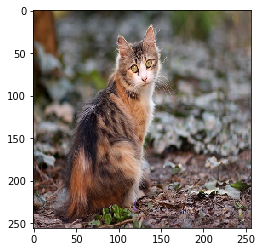

2 / 555
Etiqueta: 0


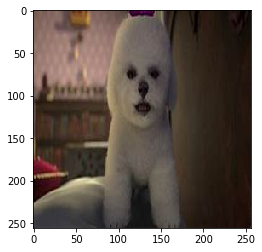

3 / 555
Etiqueta: 9


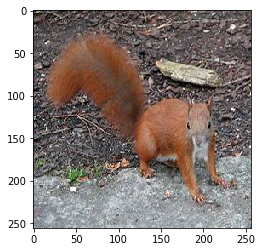

4 / 555
Etiqueta: 4


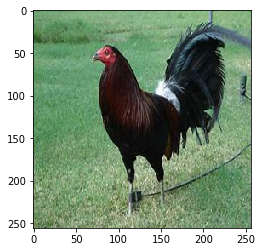

In [3]:
# Modifique la siguiente ruta acorde a su entorno de desarrollo
hdf5_path = '../data/animals/data_animals.h5'
batch_size = 50
batch_n = 4
hdf5_file = read_h5_dataset(hdf5_path, batch_size, batch_n)
hdf5_file.close()

1 / 555
Etiqueta: 2


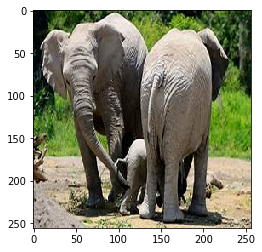

2 / 555
Etiqueta: 2


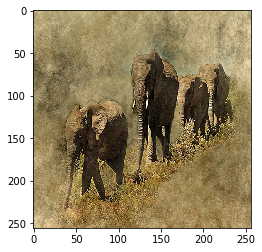

3 / 555
Etiqueta: 9


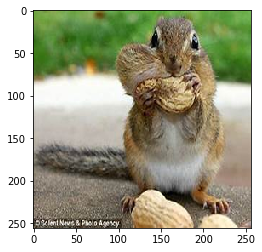

4 / 555
Etiqueta: 0


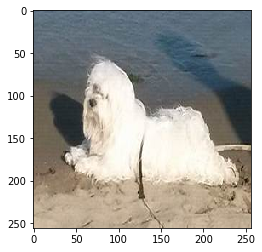

['test_img', 'test_labels', 'train_img', 'train_labels', 'train_mean']

In [4]:
hdf5_file = read_h5_dataset(hdf5_path, batch_size, batch_n)

list(hdf5_file.keys())